In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

import shap

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

from pysymbolic.models.special_functions import MeijerG

import sys, os, time

import scipy as sc
import itertools
import copy

from mpmath import *
from sympy import *

from sympy.utilities.autowrap import ufuncify

from pysymbolic.models.special_functions import *

from tqdm import tqdm, trange, tqdm_notebook, tnrange

import warnings
warnings.filterwarnings("ignore")
if not sys.warnoptions:
    warnings.simplefilter("ignore")

from sklearn.preprocessing import PolynomialFeatures

from sklearn.linear_model import Ridge
from sympy import Integral, Symbol
from sympy.abc import x, y

In [2]:
df = pd.read_csv('/Users/janiceliu/Documents/PhD research/Research Progress/BMP/Code/df_X_VS_trans.csv', index_col = 0, header = 0)

k = df['k']
X = df[['Lipid', 'Lignin', 'Protein']]

In [3]:
X_train_k, X_test_k, k_train, k_test = train_test_split(X, k)
xgb_k = xgb.XGBRegressor(early_stopping_rounds = 10, gamma = 1e-5, learning_rate = 0.2, max_depth = 4)
xgb_k.fit(X_train_k, k_train, eval_set = [(X_test_k, k_test)], verbose = False)

k_pred_for_meta = xgb_k.predict(X_train_k)

X1 = np.array(X_train_k.iloc[:,0])
X2 = np.array(X_train_k.iloc[:,1])
X3 = np.array(X_train_k.iloc[:,2])

feature_expander = PolynomialFeatures(2, include_bias=False, interaction_only=True)
Interaction_features = feature_expander.fit_transform(X_train_k)

X1X2 = Interaction_features[:,3]
X1X3 = Interaction_features[:,4]
X2X3 = Interaction_features[:,5]

In [4]:
X1_test = np.array(X_test_k.iloc[:,0])
X2_test = np.array(X_test_k.iloc[:,1])
X3_test = np.array(X_test_k.iloc[:,2])

feature_expander = PolynomialFeatures(2, include_bias=False, interaction_only=True)
Interaction_features = feature_expander.fit_transform(X_test_k)

X1X2_test = Interaction_features[:,3]
X1X3_test = Interaction_features[:,4]
X2X3_test = Interaction_features[:,5]

In [5]:
k_pred_test = xgb_k.predict(X_test_k)

## Plot single dimension on test set

In [6]:
# Parameters
p1 = [0.40023032, 0.40023032, 0.40023032]		
p2 = [0.85787098, 2.15989562, 0.07531869, 0.88040071]
p3 = [1.52566966, 0.47433032, 0.47433032]
p12 = [0.02893867, 0.50123426]
p13 = [0.52183224, 0.52183224, 0.52183224]
p23 = [-0.9063, 1.60058825, 0.27187949, -1.78865278]		

# c
c1 = 1.15418943
c2 = 1.52835267
c3 = 1.26840768
c12 = 1.59547192
c13 = 1.16271507
c23 = 1.00312432

In [7]:
# Compose_feature for training set (to fit ridge coefficients)

def compose_features(p1, p2, p3, p12, p13, p23, x1, x2, x3, x1x2, x1x3, x2x3):

    try: 
        basis_X1 = MeijerG(theta = p1 + [c1], order = [3,0,0,3], evaluation_mode = 'eval').evaluate(x1)
    except:
        basis_X1 = MeijerG(theta = p1 + [c1], order = [3,0,0,3], evaluation_mode = 'numpy').evaluate(x1)

    try:
        basis_X2 = MeijerG(theta = p2 + [c2], order = [0,3,3,1], evaluation_mode = 'eval').evaluate(x2)     
    except:
        basis_X2 = MeijerG(theta = p2 + [c2], order = [0,3,3,1], evaluation_mode = 'numpy').evaluate(x2)
    try:         
        basis_X3 = MeijerG(theta = p3 + [c3], order = [2,0,1,2], evaluation_mode = 'eval').evaluate(x3)
    except:
        basis_X3 = MeijerG(theta = p3 + [c3], order = [2,0,1,2], evaluation_mode = 'numpy').evaluate(x3)
    
    try:
        basis_X1X2 = MeijerG(theta = p12 + [c12], order = [1,0,0,2], evaluation_mode = 'eval').evaluate(x1x2)
    except:
        basis_X1X2 = MeijerG(theta = p12 + [c12], order = [1,0,0,2], evaluation_mode = 'numpy').evaluate(x1x2)

    try:
        basis_X1X3 = MeijerG(theta = p13 + [c13], order = [3,0,0,3], evaluation_mode = 'eval').evaluate(x1x3)
    except:
        basis_X1X3 = MeijerG(theta = p13 + [c13], order = [3,0,0,3], evaluation_mode = 'numpy').evaluate(x1x3)

    try:
        basis_X2X3 = MeijerG(theta = p23 + [c23], order = [1,1,2,2], evaluation_mode = 'eval').evaluate(x2x3)
    except:
        basis_X2X3 = MeijerG(theta = p23 + [c23], order = [1,1,2,2], evaluation_mode = 'numpy').evaluate(x2x3)

    basis = np.array([basis_X1, basis_X2, basis_X3, basis_X1X2, basis_X1X3, basis_X2X3]).T

    return basis  

In [ ]:
x1 = np.linspace(0.001,1,100)
x2 = np.linspace(0.001,1,100)
x3 = np.linspace(0.001,1,100)

x1x2 = x1 * x2
x1x3 = x1 * x3
x2x3 = x2 * x3

In [49]:
basis = compose_features(p1, p2, p3, p12, p13, p23, x1, x2, x3, x1x2, x1x3, x2x3)

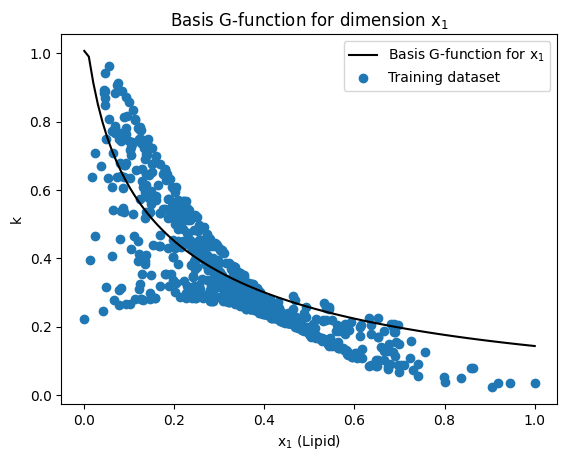

In [76]:
plt.figure()
plt.plot(x1, basis[:,0], label = 'Basis G-function for x$_{1}$', c = 'k')
plt.scatter(X1, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{1}$ (Lipid)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{1}$')
plt.show()

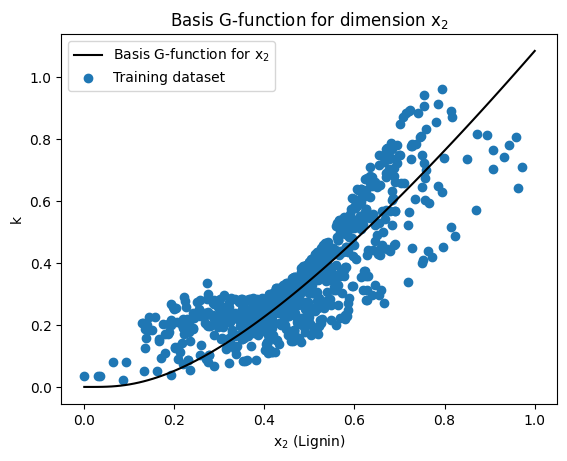

In [77]:
plt.figure()
plt.plot(x2, basis[:,1], label = 'Basis G-function for x$_{2}$', c = 'k')
plt.scatter(X2, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{2}$ (Lignin)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{2}$')
plt.show()

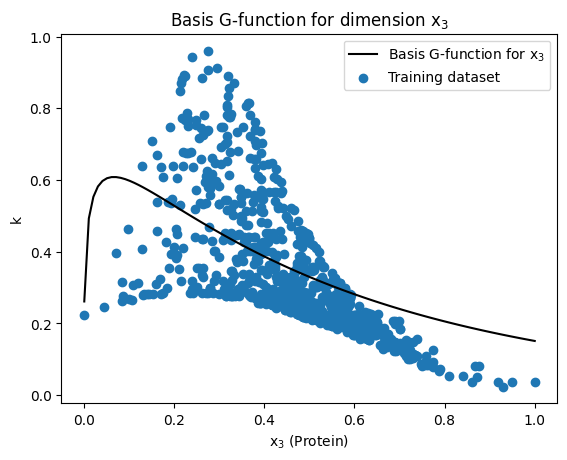

In [78]:
plt.figure()
plt.plot(x3, basis[:,2], label = 'Basis G-function for x$_{3}$', c = 'k')
plt.scatter(X3, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{3}$ (Protein)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{3}$')
plt.show()

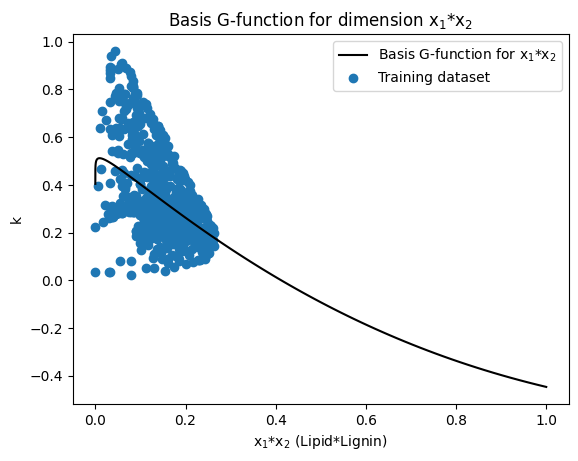

In [79]:
plt.figure()
plt.plot(x1x2, basis[:,3], label = 'Basis G-function for x$_{1}$*x$_{2}$', c = 'k')
plt.scatter(X1X2, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{1}$*x$_{2}$ (Lipid*Lignin)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{1}$*x$_{2}$')
plt.show()

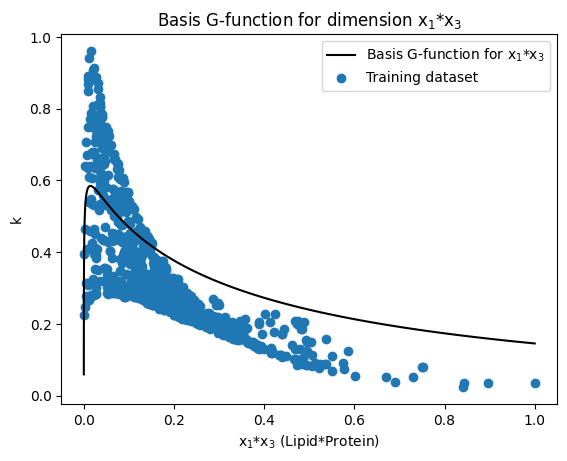

In [80]:
plt.figure()
plt.plot(x1x3, basis[:,4], label = 'Basis G-function for x$_{1}$*x$_{3}$', c = 'k')
plt.scatter(X1X3, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{1}$*x$_{3}$ (Lipid*Protein)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{1}$*x$_{3}$')
plt.show()

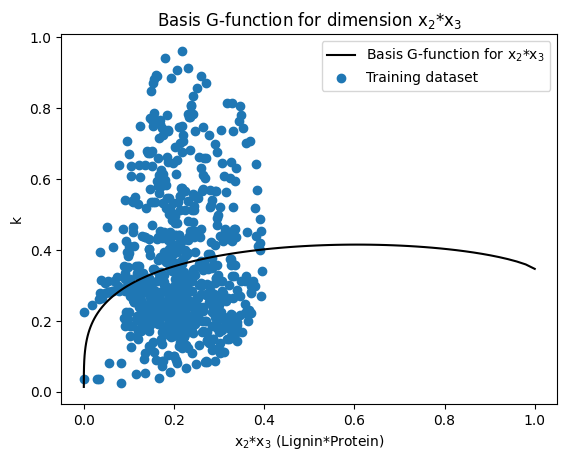

In [81]:
plt.plot(x2x3, basis[:,5], label = 'Basis G-function for x$_{2}$*x$_{3}$', c = 'k')
plt.scatter(X2X3, k_pred_for_meta, label = 'Training dataset')
plt.legend()
plt.xlabel('x$_{2}$*x$_{3}$ (Lignin*Protein)')
plt.ylabel('k')
plt.title('Basis G-function for dimension x$_{2}$*x$_{3}$')
plt.show()

## Fit a Vanilla Metamodel

Calculate R2 and Metamodel loss on test set

In [13]:
basis_test = compose_features(p1, p2, p3, p12, p13, p23, X1_test, X2_test, X3_test, X1X2_test, X1X3_test, X2X3_test)

In [14]:
Ridge_basis_test = Ridge(alpha = 0.01, fit_intercept = False)
Ridge_basis_test.fit(basis_test, k_pred_test)
curr_eval_test = Ridge_basis_test.predict(basis_test)

In [15]:
r2_vanilla_test = r2_score(k_pred_test, curr_eval_test)
print(r2_vanilla_test)

0.9271679582258257


In [94]:
loss_vanilla_test = np.mean((k_pred_test - curr_eval_test)**2)
print(loss_vanilla_test)

0.0022794112222514267


In [16]:
Ridge_basis_test.coef_

array([ 0.55019947,  0.4327389 , -1.6071898 ,  0.55043134,  1.30724852,
       -0.41289125])

Fit a ridge regression on training set

In [8]:
basis_train = compose_features(p1, p2, p3, p12, p13, p23, X1, X2, X3, X1X2, X1X3, X2X3)

In [9]:
Ridge_basis_train = Ridge(alpha = 0.01, fit_intercept = False)
Ridge_basis_train.fit(basis_train, k_pred_for_meta)
curr_eval_train = Ridge_basis_train.predict(basis_train)

In [10]:
r2_vanilla_train = r2_score(k_pred_for_meta, curr_eval_train)
print(r2_vanilla_train)

0.9283159711807198


In [11]:
Ridge_basis_train.coef_

array([ 0.88280772,  0.14921904, -2.77848496,  0.48120232,  2.25652854,
       -0.3516638 ])

## Vanilla Model Taylor Approximation

In [12]:
from copy import deepcopy

In [13]:
basis_X1= MeijerG(theta = p1 + [c1], order = [3,0,0,3])
basis_X2 = MeijerG(theta = p2 + [c2], order = [0,3,3,1])
basis_X3 = MeijerG(theta = p3 + [c3], order = [2,0,1,2])
basis_X1X2 = MeijerG(theta = p12 + [c12], order = [1,0,0,2])
basis_X1X3 = MeijerG(theta = p13 + [c13], order = [3,0,0,3])
basis_X2X3 = MeijerG(theta = p23 + [c23], order = [1,1,2,2])

In [14]:
poly_X1 = deepcopy(basis_X1)
poly_X2 = deepcopy(basis_X2)
poly_X3 = deepcopy(basis_X3)
poly_X1X2 = deepcopy(basis_X1X2)
poly_X1X3 = deepcopy(basis_X1X3)
poly_X2X3 = deepcopy(basis_X2X3)

In [15]:
poly_X1.approximation_order = 5
poly_X2.approximation_order = 5
poly_X3.approximation_order = 5
poly_X1X2.approximation_order = 5
poly_X1X3.approximation_order = 5
poly_X2X3.approximation_order = 5

In [16]:
approx_eval_test = 0.88280772 * poly_X1.evaluate(X1_test) + 0.14921904 * poly_X2.evaluate(X2_test) \
    - 2.77848496 * poly_X3.evaluate(X3_test) + 0.48120232 * poly_X1X2.evaluate(X1X2_test) + \
    2.25652854 * poly_X1X3.evaluate(X1X3_test) - 0.3516638 * poly_X2X3.evaluate(X2X3_test)

In [17]:
r2_taylor_test = r2_score(k_pred_test, approx_eval_test)
print(r2_taylor_test)

0.9072661442096093


In [18]:
loss_taylor_test = np.mean((k_pred_test - approx_eval_test)**2)
print(loss_taylor_test)

0.0029899384271414664


In [19]:
poly_X1.approx_expression()

-1.63342706002312*x**5 + 5.14085153115589*x**4 - 6.91141967075537*x**3 + 5.20435815115242*x**2 - 2.45775602533738*x + 0.778463185183736

In [20]:
poly_X2.approx_expression()

-0.486884717786007*x**5 + 1.70533716526042*x**4 - 2.70727643819408*x**3 + 2.78213169839589*x**2 - 0.216222754022626*x + 0.00208895010633529

In [21]:
poly_X3.approx_expression()

0.433092863498441*x**5 - 1.15622192158834*x**4 + 1.02765361996645*x**3 + 0.0833551636396611*x**2 - 0.936959488181631*x + 0.707845964897054

In [22]:
poly_X1X2.approx_expression()

0.150451580681917*x**5 - 0.46720997764903*x**4 + 0.490290379115344*x**3 + 0.39492611529496*x**2 - 1.57139866247043*x + 0.557860744407072

In [23]:
poly_X1X3.approx_expression()

-0.74265493758593*x**5 + 2.39742262480676*x**4 - 3.35163625987105*x**3 + 2.69688891986637*x**2 - 1.44361871920834*x + 0.57921551311091

In [24]:
poly_X2X3.approx_expression()

0.346179570371851*x**5 - 1.26920261481184*x**4 + 1.8186026493403*x**3 - 1.58047687935357*x**2 + 0.80832982212009*x + 0.243642285427083

## Metamodel for k prediction

In [ ]:
def metamodel_k(data):
    x1 = data[:,0]
    x2 = data[:,1]
    x3 = data[:,2]
    x1x2 = data[:,3]
    x1x3 = data[:,4]
    x2x3 = data[:,5]

    dim1 = - 1.63342706002312 * x1**5 + 5.14085153115589 * x1**4 - 6.91141967075537 * x1**3 + 5.20435815115242 * x**2 - 2.45775602533738 * x + 0.778463185183736
    dim2 = - 0.486884717786007 * x1**5 + 1.70533716526042 * x1**4 - 2.70727643819408 * x1**3 + 2.78213169839589 * x1**2 -  0.216222754022626 * x + 0.00208895010633529
    dim3 = 0.433092863498441 * x3**5 - 1.15622192158834 * x3**4 +  1.02765361996645 * x3**3 + 0.0833551636396611 * x3**2 - 0.936959488181631 * x3 + 0.707845964897054
    dim12 = 0.150451580681917 * x1x2**5 -  0.46720997764903 * x1x2**4 + 0.490290379115344 * x1x2**3 + 0.39492611529496 * x1x2**2 - 1.57139866247043 * x1x2 + 0.557860744407072
    dim13 = - 0.74265493758593 * x1x3**5 + 2.39742262480676 * x1x3**4 - 3.35163625987105 * x1x3**3 + 2.69688891986637 * x1x3**2 - 1.44361871920834 * x1x3 + 0.57921551311091
    dim23 = 0.346179570371851 * x2x3**5 - 1.26920261481184 * x2x3**4 + 1.8186026493403 * x2x3**3 - 1.58047687935357 * x2x3**2 + 0.80832982212009 * x2x3 + 0.243642285427083

    pred_k = 0.88280772 * dim1 + 0.14921904 * dim2 - 2.77848496 * dim3 + 0.48120232 * dim12 + 2.25652854 * dim13 - 0.3516638 * dim23

    return pred_k